# Generate the model from processed.csv

imports

In [1]:
from sklearn import clone
from sklearn.base import RegressorMixin, TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import json

Read CSV

In [2]:

df = pd.read_csv('data/processed.csv')

# makes models perform worse
# df['difficulty_transform'], lambda_value = stats.boxcox(df['difficulty'])

print(df.head())


   difficulty  average_tempo  average_bpm  note_count  tick_count  \
0         3.5  413197.921548   145.208862        3656      155036   
1         4.5  600000.000000   100.000000        3926       28352   
2         4.5  600000.000000   100.000000        3926       28352   
3         4.5  350818.280820   171.028716        2674      151680   
4         4.5  441740.064844   135.826484        3570       22816   

   note_density  tempo_deviation  unique_note_count  total_duration  \
0      0.023582     97297.985266                 65          155036   
1      0.138473         0.000000                 57           28352   
2      0.138473         0.000000                 57           28352   
3      0.017629     11112.029407                 73          452520   
4      0.156469      7352.818211                 63           43392   

   overlapping_notes  ...  odd_time_signature_count  consecutive_note_std  \
0                283  ...                         1             43.313047   
1   

## Selecting best features

In [3]:
X = df.drop(columns=['difficulty'])
y = df['difficulty']

features_names = X.columns

# Keep the best features
selector = SelectPercentile(r_regression, percentile=40)
X = selector.fit_transform(X, y)
features_kept = features_names[selector.get_support()]
print("Features kept:", features_kept)

Features kept: Index(['note_count', 'unique_note_count', 'overlapping_notes', 'pitch_range',
       'tempo_change_count', 'max_polyphony', 'note_to_note_transition',
       'note_to_chord_transition', 'chord_to_note_transition',
       'chord_to_chord_transition'],
      dtype='object')


## Scaling data and splitting
features have a large difference in scale, scaling makes model perform slightly better

In [40]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Removes randomness from the model across runs
rng = np.random.RandomState(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)


## Tuning hyperparameters

In [37]:
model_params = {
  'XGB': {
    'model': XGBRegressor(random_state=rng),
    'params': {
        'n_estimators': [100, 200, 500, 1000],
        'gamma': [0.005, 0.01, 0.1, 0],
        'max_depth': [1, 2, 3, 6, 9],
        'learning_rate': [0.001, 0.01, 0.1, 0.015, 1],
        'min_child_weight': [1, 2, 3],
    }
  },
  'RandomForest': {
    'model': RandomForestRegressor(random_state=rng),
    'params': {
      'n_estimators': [100, 200, 500],
      'max_features': ['sqrt', 'log2', None],
      'min_samples_split': [2, 5, 10],
      'max_depth': [None, 1, 2, 10, 20, 30],
      'max_leaf_nodes': [None, 2, 5, 10],
    }
  },
  'SVR': {
    'model': SVR(),
    'params': {
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'C': [0.1, 1, 10, 20, 50, 100],
      'gamma': ['scale', 'auto'],
    }
  }
}

results =  {}

for name, config in model_params.items():
  print('tuning hyperparamerts for ', name)
  # Can edit cv to be more or less, less is faster
  grid_search = GridSearchCV(config['model'], config['params'], cv=3, scoring='r2')
  grid_search.fit(X_train, y_train)
  
  results[name] = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
  }
  
  print(f"Best parameters for {name}:", grid_search.best_params_)
  print(f"Best cross-validation score for {name}:", grid_search.best_score_)

with open(f'model_params.json', 'w') as f:
    json.dump(results, f)

tuning hyperparamerts for  XGB


KeyboardInterrupt: 

In [35]:
with open ('model_params.json', 'r') as f:
    params = json.load(f)
    
models = {
    'XGB': XGBRegressor(**params['XGB']['best_params']),
    'RandomForest': RandomForestRegressor(**params['RandomForest']['best_params']),
    # 'SVR': SVR(**params['SVR']['best_params'])
}


Validation Function

In [36]:
n_folds = 5

def rmse_cross_validation(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [39]:
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    print(f"Model: {name}")
    # Round and clip to ensure valid difficulty levels
    y_pred = np.round(model.predict(X_test) * 2) / 2
    print("Mean squared error:", mean_squared_error(y_test, y_pred))
    print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
    print("R^2 score:", r2_score(y_test, y_pred))
    print("Root mean squared error:", rmse_cross_validation(model).mean())
    print("======================")
    # Save model to disk
    with open(f'./models/{name}_saved_model.pkl', 'wb') as file:
      pickle.dump(model, file)

Model: XGB
Mean squared error: 0.23113207547169812
Mean absolute error: 0.29245283018867924
R^2 score: 0.8392348644298626
Root mean squared error: 0.5717261311692846
Model: RandomForest
Mean squared error: 0.23113207547169812
Mean absolute error: 0.3113207547169811
R^2 score: 0.8392348644298626
Root mean squared error: 0.5327385353717478


## Create Buckets for each model

Do this to check where the model is performing well and where it is not. Here, we visualize it. Low is 0 - 1.5, mid is 1.5 - 3.5, high is 3.5 - 5.

bucket
1      10
1.5    10
3      10
2.5     8
4       5
4.5     5
3.5     4
5       1
2       0
Name: count, dtype: int64


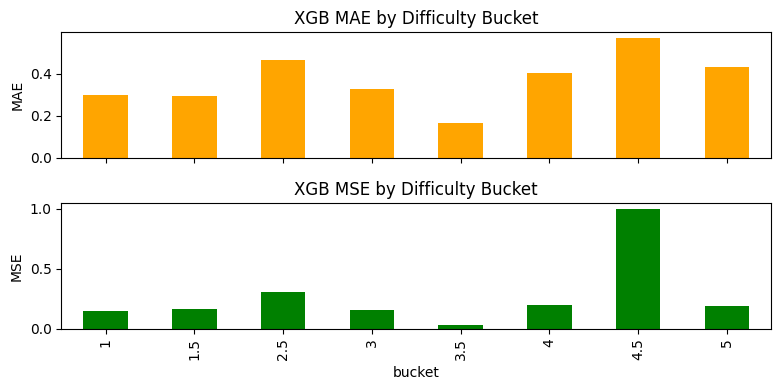

bucket
1      10
1.5    10
3      10
2.5     8
4       5
4.5     5
3.5     4
5       1
2       0
Name: count, dtype: int64


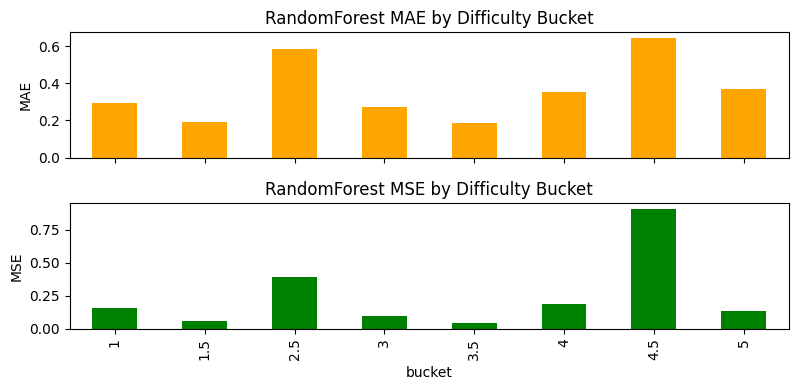

In [46]:
for name, prediction in predictions.items():
    # Comparing true values vs predicted
    df = pd.DataFrame({
      'true': y_test,
      'pred': prediction,
    })

      # Create buckets of difficulty
    df['bucket'] = pd.cut(df['true'], bins=[0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], 
              labels=['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5'], 
              include_lowest=True)
    

    print(df['bucket'].value_counts())

    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

    mae_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_absolute_error(g['true'], g['pred']))
    mae_scores.plot(kind='bar', ax=axes[0], title=f"{name} MAE by Difficulty Bucket", ylabel="MAE", color='orange', legend=False)

    mse_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_squared_error(g['true'], g['pred']))
    mse_scores.plot(kind='bar', ax=axes[1], title=f"{name} MSE by Difficulty Bucket", ylabel="MSE", color='green', legend=False)

    plt.tight_layout()
    plt.show()

## AveragingModel using the models trained earlier

In [25]:
# referenced from https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, scaler, weights_by_bucket=None):
        self.models = models
        self.scaler = scaler
        self.weights_by_bucket = weights_by_bucket

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

Validation:

In [26]:
averaged_models = AveragingModels(models=list(models.values()), scaler = scaler)
score = rmse_cross_validation(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(X_train, y_train)
y_pred = np.round(averaged_models.predict(X_test) * 2) / 2

print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

with open(f'./models/averaged_models.pkl', 'wb') as file:
    pickle.dump(averaged_models, file)



 Averaged base models score: 0.5468 (0.0851)

Mean squared error: 0.21226415094339623
Mean absolute error: 0.27358490566037735
R^2 score: 0.8523585489662003


# Predicting the difficulty for the rest of the songs

In [ ]:
with open('./models/averaged_models.pkl', 'rb') as file:
    averaged_models = pickle.load(file)

df = pd.read_csv('data/all_song_features.csv')

# Select only the columns used during training
X_unseen = df.loc[:, features_kept]

# Scale the data using the same scaler from training
X_unseen = scaler.transform(X_unseen)

y_pred = np.round(averaged_models.predict(X_unseen) * 2) / 2

predictions = pd.DataFrame({
    'file': df['file'],
    'predicted_difficulty': y_pred
}).to_csv('predictions.csv', index=False)



c:\Users\tanbi\OneDrive\Desktop\projects\music-ai\test\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
